In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

# ML Models
# ML Models
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor


from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from sklearn.model_selection import train_test_split


from lightgbm import LGBMRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Attention
from tensorflow.keras.optimizers import Adam

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Model Evaluation
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt

# Time Series Split
from sklearn.model_selection import TimeSeriesSplit


### Technnincal indicators

In [29]:

def compute_rsi(series, period=14):
    delta = series.diff()
    gains = delta.where(delta > 0, 0.0)
    losses = -delta.where(delta < 0, 0.0)
    avg_gain = gains.rolling(window=period).mean()
    avg_loss = losses.rolling(window=period).mean()
    rs = avg_gain / (avg_loss + 1e-9)
    return 100.0 - (100.0 / (1.0 + rs))

def compute_macd(series, fastperiod=12, slowperiod=26, signalperiod=9):
    ema_fast = series.ewm(span=fastperiod, adjust=False).mean()
    ema_slow = series.ewm(span=slowperiod, adjust=False).mean()
    macd_line = ema_fast - ema_slow
    signal_line = macd_line.ewm(span=signalperiod, adjust=False).mean()
    macd_hist = macd_line - signal_line
    return macd_line, signal_line, macd_hist

def compute_ma(series, window=20):
    return series.rolling(window=window).mean()


In [30]:

csv_file = "merged_news_stock_data.csv"
df = pd.read_csv(csv_file, parse_dates=["Date"])
df.sort_values("Date", inplace=True)
df.dropna(subset=["Date"], inplace=True)
df.reset_index(drop=True, inplace=True)


In [31]:

df["RSI"] = compute_rsi(df["Close_Price"])
df["MACD_line"], df["MACD_signal"], df["MACD_hist"] = compute_macd(df["Close_Price"])
df["MA20"] = compute_ma(df["Close_Price"])
df.dropna(inplace=True)
df["Close_next"] = df["Close_Price"].shift(-1)
df.dropna(inplace=True)


### Feature Selection

In [32]:

# Define the improved LSTM model code
from sklearn.preprocessing import RobustScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping



# Selecting features and target variable
features = ["RSI", "MACD_line", "MACD_signal", "MACD_hist", "MA20",
            "sentiment_polarity", "sentiment_neg", "sentiment_neu", "sentiment_pos"]
target = "Close_next"

# Handling missing values by interpolation
df.fillna(method='ffill', inplace=True)


X = df[features]
y = df[target]

# Scaling Features
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)
y_scaled = scaler.fit_transform(y.values.reshape(-1, 1)).flatten()

# Split Data Into Consistent Train/Test Sets (Used for All Models)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, shuffle=False)


## LSTM

In [33]:

# # Scaling the data using RobustScaler (better for outliers)
# scaler = RobustScaler()
# X_scaled = scaler.fit_transform(df[features])
# y_scaled = scaler.fit_transform(df[[target]])

# # Splitting the dataset
# X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, shuffle=False)

# Reshaping input data for LSTM (samples, time steps, features)
X_train_lstm = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test_lstm = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

# Building the improved LSTM model
lstm_model = Sequential([
    Bidirectional(LSTM(128, return_sequences=True, kernel_regularizer=l2(0.01)), input_shape=(1, X_train.shape[1])),
    Dropout(0.4),
    LSTM(64, return_sequences=True),
    Dropout(0.4),
    LSTM(32, return_sequences=False),
    Dropout(0.4),
    Dense(16, activation="relu"),
    Dense(1)
])

# Compiling the model with a lower learning rate and AdamW optimizer
lstm_model.compile(optimizer=tf.keras.optimizers.AdamW(learning_rate=0.0005), loss="mse")

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)

# Training the model
lstm_model.fit(X_train_lstm, y_train, epochs=100, batch_size=64, verbose=1, callbacks=[early_stopping])

# Making predictions
y_pred_lstm = lstm_model.predict(X_test_lstm).flatten()

# Evaluating performance
lstm_rmse = np.sqrt(mean_squared_error(y_test, y_pred_lstm))
lstm_r2 = r2_score(y_test, y_pred_lstm)


Epoch 1/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.7548
Epoch 2/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0763
Epoch 3/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0472
Epoch 4/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0379
Epoch 5/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0334
Epoch 6/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0321
Epoch 7/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0287
Epoch 8/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0291
Epoch 9/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0255
Epoch 10/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0262
Epoch 11/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0290
Epoch 12/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0273
Epoch 13/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0269
Epoch 14/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0248
Epoch 15/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 1

In [34]:

print(f"Improved LSTM Model - RMSE: {lstm_rmse:.4f}, R²: {lstm_r2:.4f}")


Improved LSTM Model - RMSE: 0.0568, R²: 0.9764


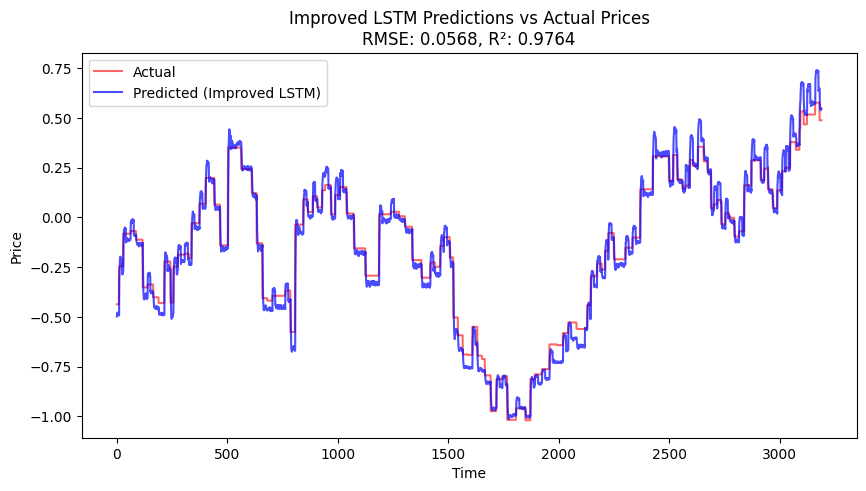

In [35]:
# Plot Actual vs Predicted Prices for Improved LSTM Model
plt.figure(figsize=(10, 5))
plt.plot(y_test, label="Actual", color="red", alpha=0.6)
plt.plot(y_pred_lstm, label="Predicted (Improved LSTM)", color="blue", alpha=0.7)
plt.title(f"Improved LSTM Predictions vs Actual Prices\nRMSE: {lstm_rmse:.4f}, R²: {lstm_r2:.4f}")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.show()

In [36]:

# # Splitting into Train, Validation, and Test Sets (70%-15%-15%)
# X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y_scaled, test_size=0.3, shuffle=False)
# X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, shuffle=False)

# # Reshaping input data for LSTM
# X_train_lstm = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
# X_val_lstm = X_val.reshape((X_val.shape[0], 1, X_val.shape[1]))
# X_test_lstm = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

# # Rebuilding the LSTM Model for Training with Validation Split
# lstm_model = Sequential([
#     Bidirectional(LSTM(128, return_sequences=True, kernel_regularizer=l2(0.01)), input_shape=(1, X_train.shape[1])),
#     Dropout(0.4),
#     LSTM(64, return_sequences=True),
#     Dropout(0.4),
#     LSTM(32, return_sequences=False),
#     Dropout(0.4),
#     Dense(16, activation="relu"),
#     Dense(1)
# ])

# # Compiling with AdamW optimizer and lower learning rate
# lstm_model.compile(optimizer=tf.keras.optimizers.AdamW(learning_rate=0.0005), loss="mse")

# # Training with validation set
# history = lstm_model.fit(X_train_lstm, y_train, epochs=50, batch_size=64, validation_data=(X_val_lstm, y_val), verbose=1)





In [37]:

# Plot Training vs. Validation Loss
# plt.figure(figsize=(8,5))
# plt.plot(history.history['loss'], label='Training Loss', color='blue')
# plt.plot(history.history['val_loss'], label='Validation Loss', color='red')
# plt.title("Training vs Validation Loss")
# plt.xlabel("Epochs")
# plt.ylabel("Loss (MSE)")
# plt.legend()
# plt.show()

In [38]:
# # Train and Test Predictions
# y_train_pred = lstm_model.predict(X_train_lstm).flatten()
# y_test_pred = lstm_model.predict(X_test_lstm).flatten()

# # Compute R² Scores
# train_r2 = r2_score(y_train, y_train_pred)
# test_r2 = r2_score(y_test, y_test_pred)

# train_r2, test_r2

## Random Forest

In [39]:
# Updated Random Forest Parameters for Further Optimization
rf_optimized_params = {
    'n_estimators': 200,  # Increased number of trees
    'max_depth': 20,  # Reduced max depth
    'min_samples_split': 10,
    'max_features': 'sqrt',
    'random_state': 42
}


# Instantiate Models
rf_optimized = RandomForestRegressor(**rf_optimized_params)

# Train Models
rf_optimized.fit(X_train, y_train)

# Make Predictions
rf_optimized_pred = rf_optimized.predict(X_test)

# Evaluate Performance
rf_optimized_rmse = mean_squared_error(y_test, rf_optimized_pred, squared=False)
rf_optimized_r2 = r2_score(y_test, rf_optimized_pred)


# Return Results
rf_optimized_rmse, rf_optimized_r2

(0.06392161733460999, 0.970095388019896)

In [40]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor


## Light GBM

In [41]:
# Optimized Model Parameters
best_lgbm = LGBMRegressor(num_leaves=40, n_estimators=500, max_depth=3, learning_rate=0.1, random_state=42)

# Fit models on training data
best_lgbm.fit(X_train, y_train)

# Predictions
lgbm_pred = best_lgbm.predict(X_test)

# Evaluate Performance
lgbm_rmse = mean_squared_error(y_test, lgbm_pred, squared=False)
lgbm_r2 = r2_score(y_test, lgbm_pred)




# Print Results
print(f"Optimized LightGBM - RMSE: {lgbm_rmse:.4f}, R²: {lgbm_r2:.4f}")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000646 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2231
[LightGBM] [Info] Number of data points in the train set: 12758, number of used features: 9
[LightGBM] [Info] Start training from score 0.027931
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

In [42]:

def evaluate_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmse = sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    return rmse, r2, y_pred


### XGBoost

In [43]:
# Optimized Model Parameters
best_xgb = XGBRegressor(subsample=1.0, n_estimators=500, max_depth=3, learning_rate=0.1, random_state=42)

# Fit models on training data
best_xgb.fit(X_train, y_train)

# Predictions
xgb_pred = best_xgb.predict(X_test)



xgb_rmse = mean_squared_error(y_test, xgb_pred, squared=False)
xgb_r2 = r2_score(y_test, xgb_pred)


# Print Results
print(f"Optimized XGBoost - RMSE: {xgb_rmse:.4f}, R²: {xgb_r2:.4f}")


Optimized XGBoost - RMSE: 0.0346, R²: 0.9912


In [44]:

# ts_split = TimeSeriesSplit(n_splits=5)
# feature_cols = ["RSI", "MACD_line", "MACD_signal", "MACD_hist", "MA20", "sentiment_polarity", "sentiment_neg", "sentiment_neu", "sentiment_pos"]
# X = df[feature_cols]
# y = df["Close_next"]
# train_index, test_index = list(ts_split.split(X))[-1]
# X_train, X_test = X.iloc[train_index], X.iloc[test_index]
# y_train, y_test = y.iloc[train_index], y.iloc[test_index]


In [45]:

# Linear Regression
lr_model = LinearRegression()
lr_rmse, lr_r2, lr_pred = evaluate_model(lr_model, X_train, X_test, y_train, y_test)




In [46]:
# Gradient Boosting
gb_model = GradientBoostingRegressor(n_estimators=100, max_depth=5, random_state=42)
gb_rmse, gb_r2, gb_pred = evaluate_model(gb_model, X_train, X_test, y_train, y_test)


In [47]:
# SVR
svr_model = SVR(kernel='rbf')
svr_rmse, svr_r2, svr_pred = evaluate_model(svr_model, X_train, X_test, y_train, y_test)


In [48]:

# Results Dictionary
results = {
    "LinearRegression": (lr_rmse, lr_r2, lr_pred),
    "RandomForest": (rf_optimized_rmse, rf_optimized_r2, rf_optimized_pred),
    "XGBoost": (xgb_rmse, xgb_r2, xgb_pred),
    "LightGBM": (lgbm_rmse, lgbm_r2, lgbm_pred),
    "GradientBoosting": (gb_rmse, gb_r2, gb_pred),
    "SVR": (svr_rmse, svr_r2, svr_pred),
    "LSTM": (lstm_rmse, lstm_r2, y_pred_lstm)
}

In [49]:
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt

def evaluate_model(model, X_train, X_test, y_train, y_test):
    """Trains the model, makes predictions, and evaluates performance."""
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmse = sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    return rmse, r2, y_pred


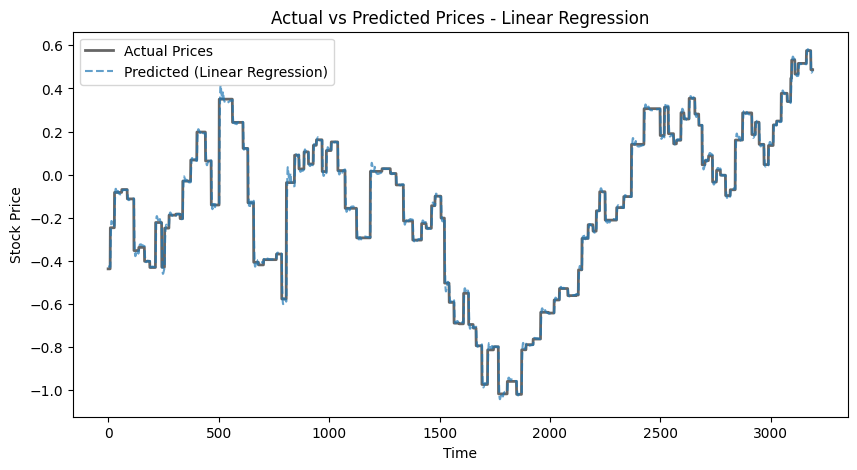

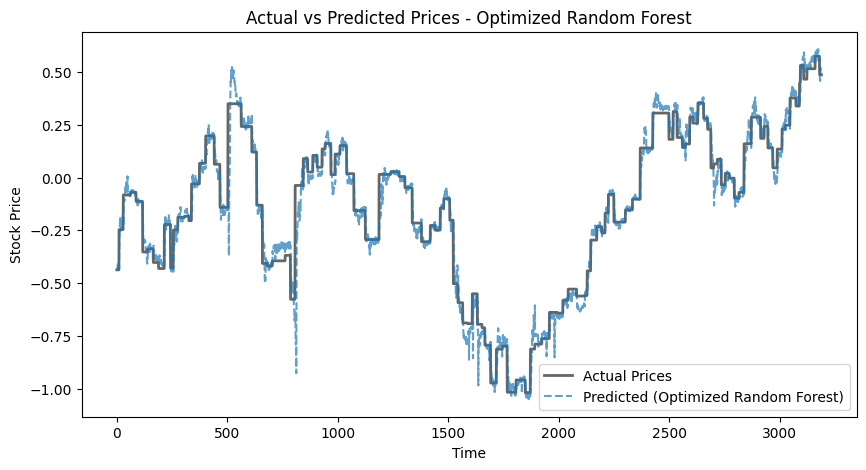

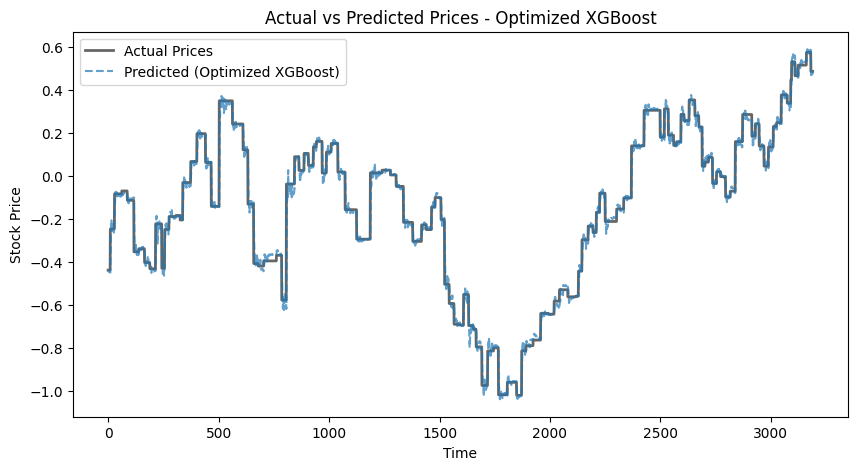

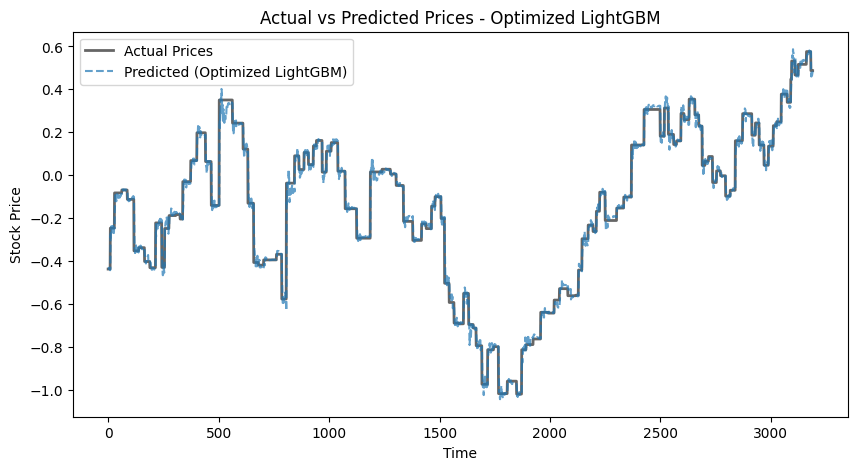

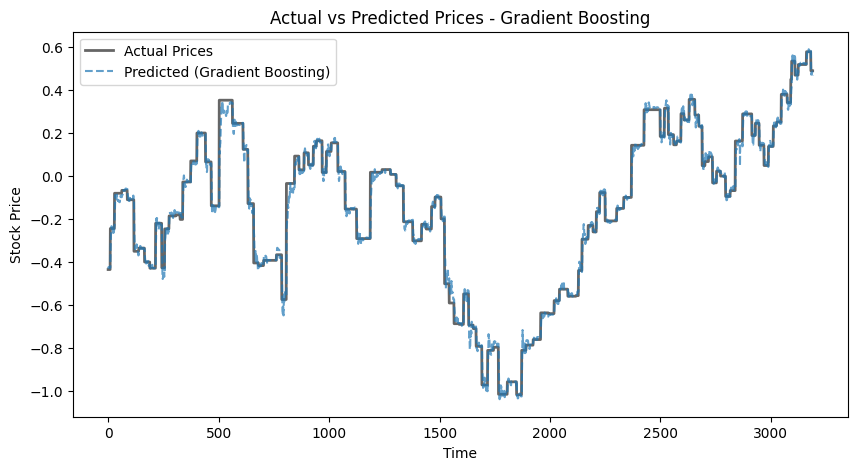

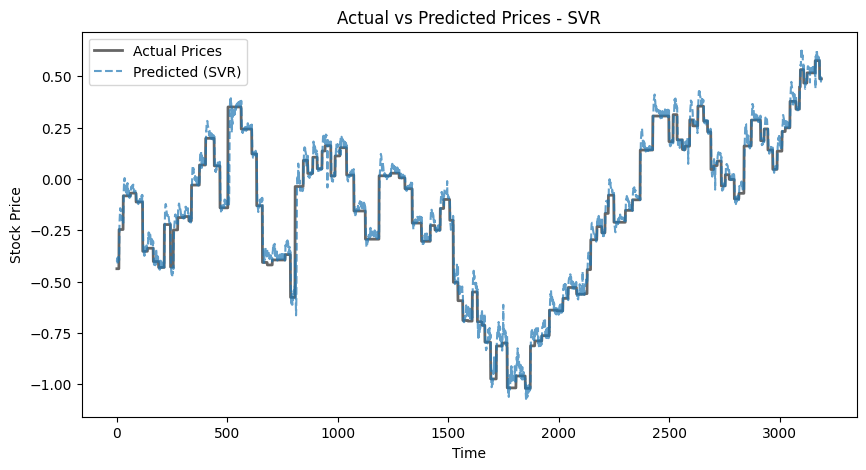

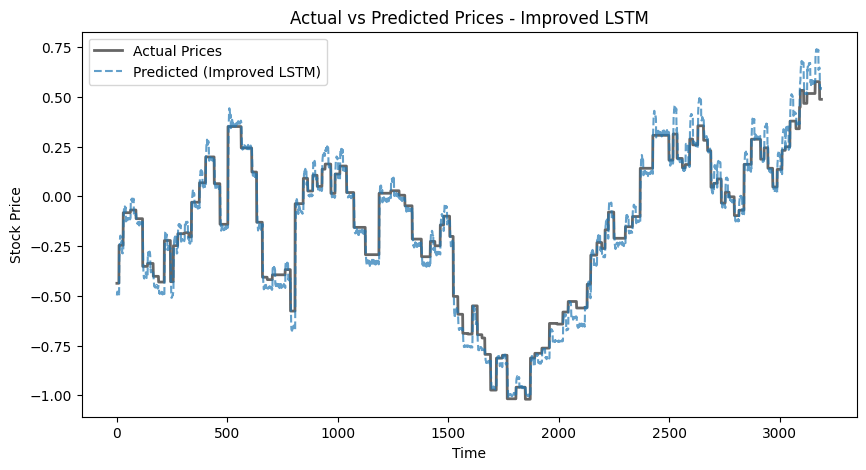

In [50]:
import matplotlib.pyplot as plt

# Define Model Predictions
model_predictions = {
    "Linear Regression": lr_pred,
    "Optimized Random Forest": rf_optimized_pred,
    "Optimized XGBoost": xgb_pred,
    "Optimized LightGBM": lgbm_pred,
    "Gradient Boosting": gb_pred,
    "SVR": svr_pred,
    "Improved LSTM": y_pred_lstm,
}

# Plot Each Model Separately
for model_name, predictions in model_predictions.items():
    plt.figure(figsize=(10, 5))
    plt.plot(y_test, label="Actual Prices", color="black", linewidth=2, alpha=0.6)
    plt.plot(predictions, label=f"Predicted ({model_name})", linestyle="dashed", alpha=0.7)
    plt.title(f"Actual vs Predicted Prices - {model_name}")
    plt.xlabel("Time")
    plt.ylabel("Stock Price")
    plt.legend()
    plt.show()


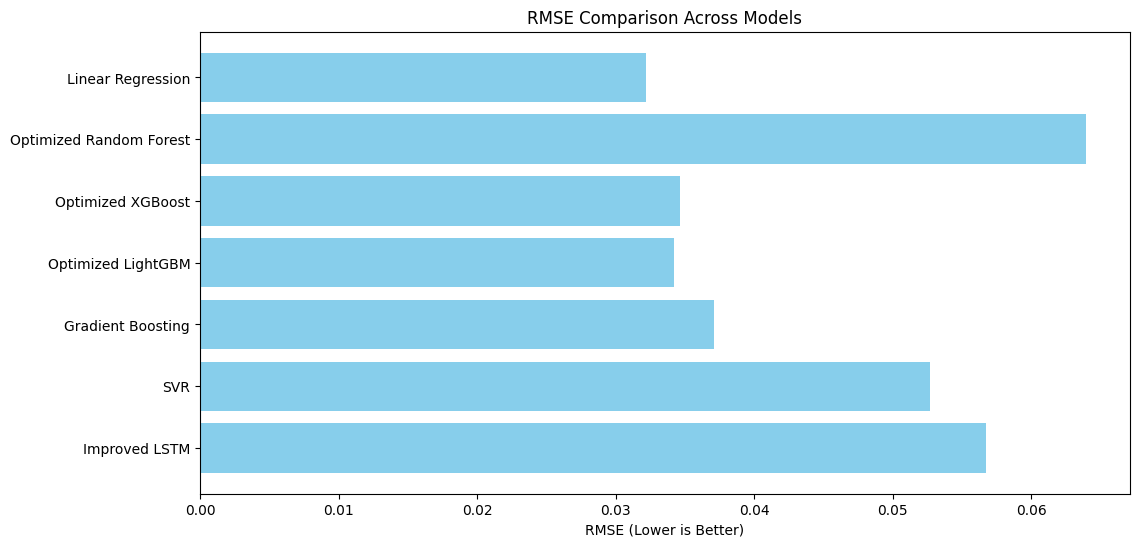

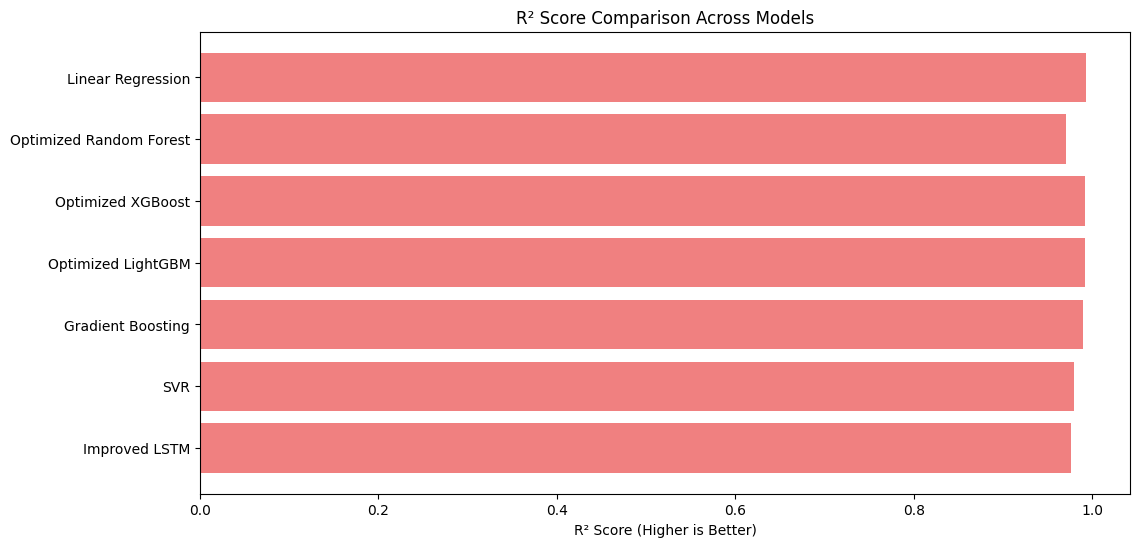

In [51]:
import pandas as pd

# Model Names
models = ["Linear Regression", "Optimized Random Forest", "Optimized XGBoost", 
          "Optimized LightGBM", "Gradient Boosting", "SVR", "Improved LSTM"]

# Replace with actual RMSE & R² values from your model results
rmse_values = [lr_rmse, rf_optimized_rmse, xgb_rmse, lgbm_rmse, gb_rmse, svr_rmse, lstm_rmse]
r2_values = [lr_r2, rf_optimized_r2, xgb_r2, lgbm_r2, gb_r2, svr_r2, lstm_r2]

# Create DataFrame for Comparison
results_df = pd.DataFrame({"Model": models, "RMSE": rmse_values, "R²": r2_values})

# Plot RMSE Comparison
plt.figure(figsize=(12, 6))
plt.barh(results_df["Model"], results_df["RMSE"], color='skyblue')
plt.xlabel("RMSE (Lower is Better)")
plt.title("RMSE Comparison Across Models")
plt.gca().invert_yaxis()
plt.show()

# Plot R² Score Comparison
plt.figure(figsize=(12, 6))
plt.barh(results_df["Model"], results_df["R²"], color='lightcoral')
plt.xlabel("R² Score (Higher is Better)")
plt.title("R² Score Comparison Across Models")
plt.gca().invert_yaxis()
plt.show()
